In [6]:
# Main imports
import curiosidade
import torch
import torch.nn


# Example imports
import functools

import numpy as np
import torch.nn.functional as F
import transformers
import datasets
import torchmetrics
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup pretrained model

In [3]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
bert = transformers.DistilBertModel.from_pretrained("distilbert-base-uncased")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Setup probing tasks

### Set up probing dataset for Binary SentLen task

In the Sentence Length (SentLen) probing task, the probing model must infer the sentence length of the original input. The challenge relies on the fact that we are going to pool away (by averaging) the axis corresponding to individual tokens, and hence de probing model must rely only the average pretrained activations to solve the task. Since probing tasks relies on classification tasks, the sentence lengths are binned in order to form the labels.

In this example we'll build an even easier sentlen task: a binary sentlen, which consists of simply deciding whether an input sentence is smaller than 256 subword tokens or not. The purpose of this simplification is to showcase the usage of the binary cross-entropy loss function with this framework. A more realistic version of the SentLen task will be showcased on a future example.

In [39]:
dataset_train, dataset_test = datasets.load_dataset("imdb", split=["train", "test"])

def tokenize_fn(item):
    sentlen_label = min(len(tokenizer.encode(item["text"])), 512)
    sentlen_label = float(max(1, np.ceil(sentlen_label / 256) - 1))
    
    new_item = tokenizer(item["text"], truncation=True, padding="max_length")
    new_item["label"] = sentlen_label
    
    return new_item

dataset_train = dataset_train.shard(num_shards=20, index=0)
dataset_eval = dataset_test.shard(num_shards=100, index=0)
dataset_test = dataset_test.shard(num_shards=100, index=2)

dataset_train = dataset_train.map(tokenize_fn, remove_columns="text")
dataset_eval = dataset_eval.map(tokenize_fn, remove_columns="text")
dataset_test = dataset_test.map(tokenize_fn, remove_columns="text")

dataset_train.set_format("torch")
dataset_eval.set_format("torch")
dataset_test.set_format("torch")

Reusing dataset imdb (/home/felsiq/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:01<00:00, 140.45ex/s]


In [40]:
probing_dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=32,
    shuffle=True,
)

probing_dataloader_eval = torch.utils.data.DataLoader(
    dataset_eval,
    batch_size=32,
    shuffle=False,
)

probing_dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=32,
    shuffle=False,
)

### Set up probing model architecture

In [41]:
probing_model_fn = curiosidade.probers.utils.get_probing_model_for_sequences(
    hidden_layer_dims=[256, 128],
    pooling_strategy="mean",
)

### Set up probing task

In [42]:
acc_fn = torchmetrics.Accuracy(num_classes=1).to("cuda")
f1_fn = torchmetrics.F1Score(num_classes=1).to("cuda")


def metrics_fn(logits, truth_labels):
    acc = acc_fn(logits, truth_labels).detach().cpu().item()
    f1 = f1_fn(logits, truth_labels).detach().cpu().item()
    return {"accuracy": acc, "f1": f1}


loss_fn = lambda logits, labels: F.binary_cross_entropy_with_logits(logits, labels.float())

task = curiosidade.ProbingTaskCustom(
    probing_dataloader_train=probing_dataloader_train,
    probing_dataloader_eval=probing_dataloader_eval,
    probing_dataloader_test=probing_dataloader_test,
    loss_fn=loss_fn,
    task_name="distilbert binary sentlen (example #2)",
    output_dim=1,
    metrics_fn=metrics_fn,
)


optim_fn = functools.partial(torch.optim.Adam, lr=0.025)
lr_scheduler_fn = functools.partial(torch.optim.lr_scheduler.ExponentialLR, gamma=0.5)

probing_factory = curiosidade.ProbingModelFactory(
    task=task,
    probing_model_fn=probing_model_fn,
    optim_fn=optim_fn,
    lr_scheduler_fn=lr_scheduler_fn,
)

prober_container = curiosidade.core.attach_probers(
    base_model=bert,
    probing_model_factory=probing_factory,
    modules_to_attach="transformer.layer.[13]",
    device="cuda",
    prune_unrelated_modules="infer",
)

prober_container

ProbingModelContainer:
(a): Base model: InferencePrunerExtensor(HuggingfaceAdapter(DistilBertModel(
 |  |  (embeddings): Embeddings(
 |  |    (word_embeddings): Embedding(30522, 768, padding_idx=0)
 |  |    (position_embeddings): Embedding(512, 768)
 |  |    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 |  |    (dropout): Dropout(p=0.1, inplace=False)
 |  |  )
 |  |  (transformer): Transformer(
 |  |    (layer): ModuleList(
 |  |      (0): TransformerBlock(
 |  |        (attention): MultiHeadSelfAttention(
 |  |          (dropout): Dropout(p=0.1, inplace=False)
 |  |          (q_lin): Linear(in_features=768, out_features=768, bias=True)
 |  |          (k_lin): Linear(in_features=768, out_features=768, bias=True)
 |  |          (v_lin): Linear(in_features=768, out_features=768, bias=True)
 |  |          (out_lin): Linear(in_features=768, out_features=768, bias=True)
 |  |        )
 |  |        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

### Train probing model

In [43]:
probing_results = prober_container.train(
    num_epochs=5,
    show_progress_bar="epoch",
    gradient_accumulation_steps=2,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:54<00:00,  1.36s/it]


## Analyzing results

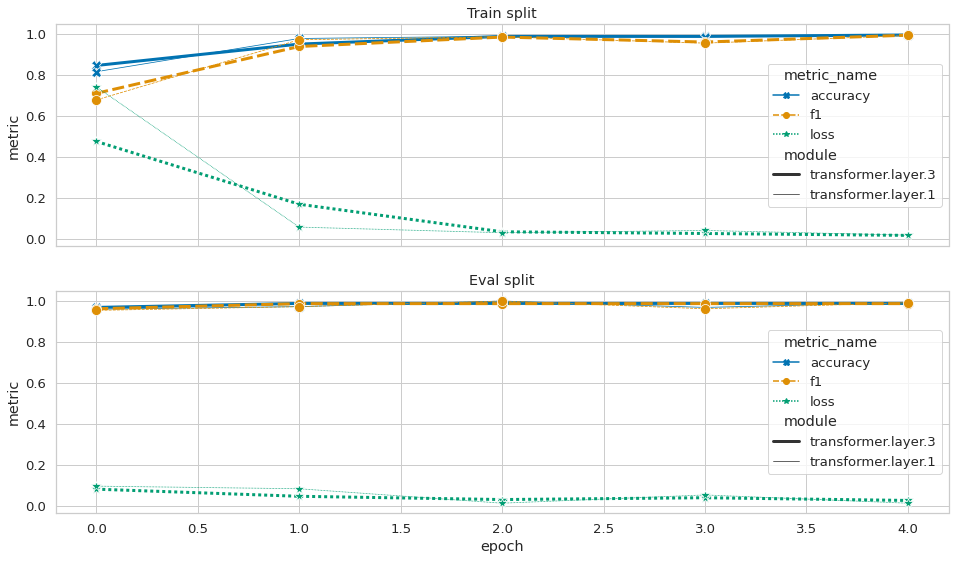

In [44]:
sns.set_theme(
    context="notebook",
    style="whitegrid",
    font_scale=1.2,
    palette="colorblind",
)

fig, (ax_train, ax_eval) = plt.subplots(2, figsize=(16, 9), sharey=True, sharex=True)

df_train, df_eval, df_test = probing_results.to_pandas(aggregate_by=["batch_index"])

common_kwargs = dict(
    hue="metric_name",
    y="metric",
    x="epoch",
    size="module",
    style="metric_name",
    markers=["X", "o", "*"],
    markersize=10,
    size_order=["transformer.layer.3", "transformer.layer.1"],
)

sns.lineplot(data=df_train, ax=ax_train, **common_kwargs)
sns.lineplot(data=df_eval, ax=ax_eval, **common_kwargs)

ax_train.set_title("Train split")
ax_eval.set_title("Eval split")

plt.show();

In [48]:
df_test

,epoch,metric_name,module,metric
0,-1,accuracy,transformer.layer.1,0.983474
1,-1,accuracy,transformer.layer.3,0.987380
2,-1,f1,transformer.layer.1,0.976004
3,-1,f1,transformer.layer.3,0.982583
4,-1,loss,transformer.layer.1,0.026887
5,-1,loss,transformer.layer.3,0.028054
